In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [3]:
dxx=0.5
dyy=dxx

In [4]:
plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

In [5]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

## Spectral Analysis

#### Test - SST and Heatflux

In [71]:
chunks_new={'dayofyear':40}

In [47]:
tt.shape

(214, 1520, 1000)

In [70]:
# tt[0,:,300:-100].plot(x='nav_lon_rho',y='nav_lat_rho',cmap='jet')

In [69]:
varf

<xarray.Dataset>
Dimensions:              (y_rho: 1520, x_rho: 1000, y_u: 1520, x_u: 999, y_v: 1519, x_v: 1000, y_w: 1520, x_w: 1000, time_counter: 852, axis_nbounds: 2)
Coordinates:
    nav_lat_rho          (y_rho, x_rho) float32 dask.array<chunksize=(1520, 1000), meta=np.ndarray>
    nav_lon_rho          (y_rho, x_rho) float32 dask.array<chunksize=(1520, 1000), meta=np.ndarray>
    nav_lat_u            (y_u, x_u) float32 dask.array<chunksize=(1520, 999), meta=np.ndarray>
    nav_lon_u            (y_u, x_u) float32 dask.array<chunksize=(1520, 999), meta=np.ndarray>
    nav_lat_v            (y_v, x_v) float32 dask.array<chunksize=(1519, 1000), meta=np.ndarray>
    nav_lon_v            (y_v, x_v) float32 dask.array<chunksize=(1519, 1000), meta=np.ndarray>
    nav_lat_w            (y_w, x_w) float32 dask.array<chunksize=(1520, 1000), meta=np.ndarray>
    nav_lon_w            (y_w, x_w) float32 dask.array<chunksize=(1520, 1000), meta=np.ndarray>
    time_instant         (time_counter) datetime64[ns] dask.array<chunksize=(124,), meta=np.ndarray>
  * time_counter         (time_counter) datetime64[ns] 2012-01-01T06:00:00 .....
Dimensions without coordinates: y_rho, x_rho, y_u, x_u, y_v, x_v, y_w, x_w, axis_nbounds
Data variables: (12/43)
    s_rho                float32 -0.00625
    s_w                  float32 0.0
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(124, 2), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(124, 2), meta=np.ndarray>
    hc                   float64 200.0
    theta_s              float64 6.0
    ...                   ...
    v                    (time_counter, y_v, x_v) float32 dask.array<chunksize=(124, 1519, 1000), meta=np.ndarray>
    w                    (time_counter, y_rho, x_rho) float32 dask.array<chunksize=(124, 1520, 1000), meta=np.ndarray>
    omega                (time_counter, y_w, x_w) float32 dask.array<chunksize=(124, 1520, 1000), meta=np.ndarray>
    temp                 (time_counter, y_rho, x_rho) float32 dask.array<chunksize=(124, 1520, 1000), meta=np.ndarray>
    salt                 (time_counter, y_rho, x_rho) float32 dask.array<chunksize=(124, 1520, 1000), meta=np.ndarray>
    rho                  (time_counter, y_rho, x_rho) float32 dask.array<chunksize=(124, 1520, 1000), meta=np.ndarray>
Attributes: (12/49)
    name:                      Out/AVG_Y2012M01/SASI_6h_his
    description:               Created by xios
    Conventions:               CF-1.6
    timeStamp:                 2020-Jul-30 22:12:58 GMT
    uuid:                      1e6e6c86-13c6-4527-ac3f-51b9c243770b
    title:                     SASI
    ...                        ...
    sponge_expl:               Sponge parameters : extent (m) & viscosity (m2...
    SRCS:                      main.F step.F read_inp.F timers_roms.F init_sc...
    CPP-options:               REGIONAL SASI DIAGNOSTICS_EDDY DIAGNOSTICS_TS ...
    history:                   Sun Apr 17 12:57:27 2022: ncwa -a s_rho tmp2.n...
    NCO:                       "4.6.0"
    nco_openmp_thread_number:  1

In [88]:
%%time
chunks_new={'dayofyear':40}


tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,:,300:-100].compute();
tf=tf[:,1:-1,1:-1]

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,:,300:-100].compute();
tt=tt[:,1:-1,1:-1]


CPU times: user 40.3 s, sys: 4.55 s, total: 44.9 s
Wall time: 4.62 s


In [89]:

hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf[:,:,300:-100].compute();
hf=hf[:,1:-1,1:-1]

ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
ht=ht.chunk(chunks=chunks_new);
ht=ht[:,:,300:-100].compute();
ht=ht[:,1:-1,1:-1]


In [90]:
usf=varf.sustr.groupby("time_counter.dayofyear").mean()
usf=usf.chunk(chunks=chunks_new);
usf=usf.compute();

ust=vart.sustr.groupby("time_counter.dayofyear").mean()
ust=ust.chunk(chunks=chunks_new);
ust=ust.compute();


vsf=varf.svstr.groupby("time_counter.dayofyear").mean()
vsf=vsf.chunk(chunks=chunks_new);
vsf=vsf.compute();

vst=vart.svstr.groupby("time_counter.dayofyear").mean()
vst=vst.chunk(chunks=chunks_new);
vst=vst.compute();



usf,vsf,_=romspickle.uvw2rho_3d(usf,vsf,usf)
ust,vst,_=romspickle.uvw2rho_3d(ust,vst,vst)

usf,vsf=usf[:,:,300:-100],vsf[:,:,300:-100]
ust,vst=ust[:,:,300:-100],vst[:,:,300:-100]


In [91]:
wstf=usf.copy()
wstt=ust.copy()


wstf.data=np.sqrt(usf.data**2+vsf.data**2)
wstt.data=np.sqrt(ust.data**2+vst.data**2)



In [92]:
mask_test=tf[0].to_numpy().copy()
# mask_test=varf.temp[0].to_numpy().copy()
mask=mask_test.copy()
mask[~np.isnan(mask_test)]=np.nan;
mask[np.isnan(mask_test)]=0;

In [93]:
print(tf.shape)
print(vst.shape)
print(ust.shape)

(214, 1518, 598)
(214, 1518, 598)
(214, 1518, 598)


In [167]:
t_ind[70]

<xarray.DataArray 'time_counter' ()>
array('2012-03-11T09:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    dayofyear  int64 71

In [177]:
indstart=126;
indend=131;

# indstart=55;
# indend=70;


up_tf=tf[indstart:indend].mean(axis=0)
up_tt=tt[indstart:indend].mean(axis=0)


up_hf=hf[indstart:indend].mean(axis=0)
up_ht=ht[indstart:indend].mean(axis=0)



up_usf=usf[indstart:indend].mean(axis=0)
up_ust=ust[indstart:indend].mean(axis=0)

up_vsf=vsf[indstart:indend].mean(axis=0)
up_vst=vst[indstart:indend].mean(axis=0)



up_wsf=wstf[indstart:indend].mean(axis=0)
up_wst=wstt[indstart:indend].mean(axis=0)


In [178]:
up_hf.max()

<xarray.DataArray 'shflx' ()>
array(-11.4225235, dtype=float32)

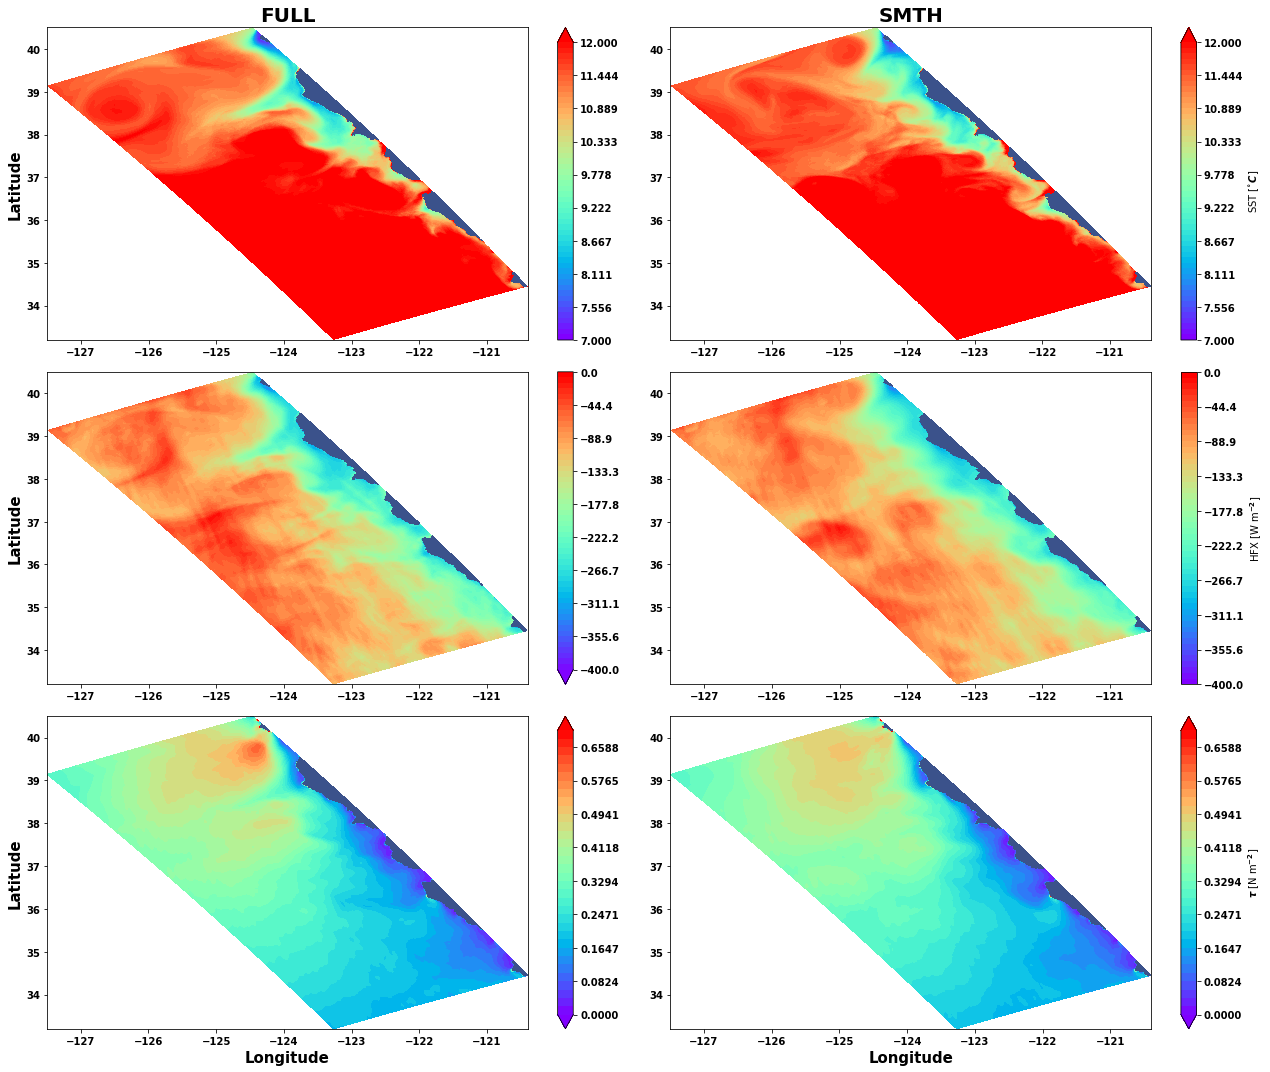

In [183]:
plt.figure(figsize=(18,15))
plt.subplot(3,2,1)
u1=up_tf.plot(x='nav_lon_rho',y='nav_lat_rho',cmap='rainbow',levels=np.linspace(7,12,55),
             cbar_kwargs={'label':''})
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,mask)
plt.title('FULL',fontsize=20,fontweight='bold')
plt.xlabel('',fontsize=15,fontweight='bold')
plt.ylabel('Latitude',fontsize=15,fontweight='bold')

plt.subplot(3,2,2)
u2=up_tt.plot(x='nav_lon_rho',y='nav_lat_rho',cmap='rainbow',levels=np.linspace(7,12,55),
              cbar_kwargs={'label':r'SST [$^{\circ}C $]'})
plt.contourf(tt.nav_lon_rho,tt.nav_lat_rho,mask)
plt.title('SMTH',fontsize=20,fontweight='bold')
plt.xlabel('',fontsize=15,fontweight='bold')
plt.ylabel('',fontsize=15,fontweight='bold')


plt.subplot(3,2,3)
u3=up_hf.plot(x='nav_lon_rho',y='nav_lat_rho',cmap='rainbow',levels=np.linspace(-400,0,55),
             cbar_kwargs={'label':''})
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,mask)
# plt.title('FULL',fontsize=20,fontweight='bold')
plt.xlabel('',fontsize=15,fontweight='bold')
plt.ylabel('Latitude',fontsize=15,fontweight='bold')

plt.subplot(3,2,4)
u4=up_ht.plot(x='nav_lon_rho',y='nav_lat_rho',cmap='rainbow',levels=np.linspace(-400,0,55),
              cbar_kwargs={'label':r'HFX [W m$^{-2}$]'})
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,mask)
# plt.title('SMTH',fontsize=20,fontweight='bold')
plt.xlabel('',fontsize=15,fontweight='bold')
plt.ylabel('',fontsize=15,fontweight='bold')



plt.subplot(3,2,5)
u5=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho.data,up_wsf,levels=np.linspace(0,0.7,35),extend='both',cmap='rainbow')
dec=50
# plt.quiver(tf.nav_lon_rho[::dec,::dec],tf.nav_lat_rho[::dec,::dec],up_usf[::dec,::dec],up_vsf[::dec,::dec])
plt.colorbar(u5)
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,mask)
# plt.title('FULL',fontsize=20,fontweight='bold')
plt.xlabel('Longitude',fontsize=15,fontweight='bold')
plt.ylabel('Latitude',fontsize=15,fontweight='bold')


plt.subplot(3,2,6)
u6=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho.data,up_wst,levels=np.linspace(0,0.7,35),extend='both',cmap='rainbow')
dec=50
# plt.quiver(tt.nav_lon_rho[::dec,::dec],tt.nav_lat_rho[::dec,::dec],up_ust[::dec,::dec],up_vst[::dec,::dec])
cb6=plt.colorbar(u6)
cb6.set_label(label=r'$\tau$ [N m$^{-2}$]')
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,mask)
# plt.title('SMTH',fontsize=20,fontweight='bold')
plt.xlabel('Longitude',fontsize=15,fontweight='bold')
plt.ylabel('',fontsize=15,fontweight='bold')

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/upwelling_front/upwelling_differences_{0}_{1}.png'.format(indstart,indend))


